In [2]:
import h5py
import numpy as np
stim='DM'

all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

#get the time dimension of each layer
all_layers_time_shape=[]
save_features_dir = f'../data/{stim}_clips_cochresnet50/'
file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
for layer in all_layers:
    all_layers_time_shape.append(file[layer].shape[1])
all_layers_time_shape

[211, 6784, 3392, 13568, 13824, 14336, 14336, 2048]

In [2]:
save_features_dir = f'../data/{stim}_clips_cochresnet50/'
file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
for layer in all_layers:
    print(layer)
    print(file[layer].shape)

input_after_preproc
(749, 82290)
conv1_relu1
(749, 1322880)
maxpool1
(749, 332416)
layer1
(749, 1329664)
layer2
(749, 677376)
layer3
(749, 358400)
layer4
(749, 186368)
avgpool
(749, 2048)


In [3]:
test=np.asanyarray(file['input_after_preproc'])
file.close()
test.shape

(749, 82290)

In [4]:
test2=np.reshape(test, (test.shape[0],211,-1))
test2.shape

(749, 211, 390)

In [5]:
import matplotlib.pyplot as plt

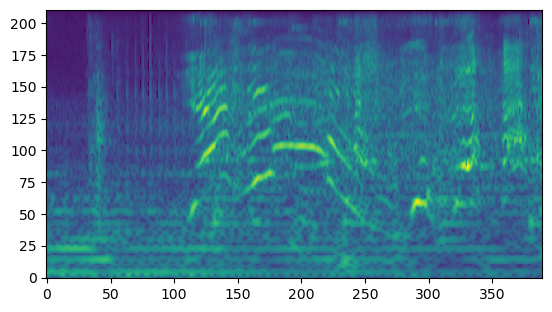

In [6]:
plt.imshow(test2[0,:,:],origin='lower')

In [12]:
test2.shape

(749, 211, 390)

For spectrogram:

for each of the 749 time points:
- there are 390 time points and 211 bins
- flatten the bins/third dimension and apply PCA across the flattened dimension
- Then average across time???

## plot 100 TRs and plots of the cochleagram and PCA features as gif

In [147]:
from sklearn.decomposition import PCA
n_components=20
transformer = PCA(n_components=n_components)
for ind in range(100):
    X=transformer.fit_transform(test2[ind,:,:].T)
    
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 7))  # Adjust the size as needed
    axs = axs.flatten()
    ax = axs[0]
    ax.imshow(test2[ind,:,:],origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'cochleagram input, {test2[ind,:,:].shape}')
    
    ax = axs[1]
    ax.imshow(X.T,origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'PCA(cochleagram input), {X.T.shape}')
    
    ax = axs[2]
    X2=test2[ind,:,:].T
    ax.imshow( np.expand_dims(np.mean(X2,axis=0), axis=0).T ,origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'mean(cochleagram input), {np.expand_dims(np.mean(X2,axis=0), axis=0).T.shape}')
    
    ax = axs[3]
    ax.imshow( np.expand_dims(np.mean(X,axis=0), axis=0).T ,origin='lower',interpolation='nearest',aspect='auto')
    ax.set_title(f'mean( PCA(cochleagram input), {np.expand_dims(np.mean(X,axis=0), axis=0).T.shape})')
    
    fig.suptitle(f'DM, TR {ind:03d}', fontsize=16)
    
    plt.tight_layout()
    fig.savefig(f'../plots/temp/gif_{ind:03d}.png')
    plt.close()



In [156]:
from PIL import Image, ImageDraw, ImageFont
import os
import numpy as np
features=['gif']
for feature in features:
    filelist=[]
    import os
    for root, dirs, files in os.walk(f'../plots/temp/'):
        for name in files:
            filelist.append(os.path.join(root, name))

    append_images=[]
    for i,f in enumerate(filelist):
        if i==0:
            img1 = Image.open(f)
        else:
            img2 = Image.open(f)
            append_images.append(img2)
    img1.save(f'../plots/{feature}_PCA_explore.gif', save_all=True, append_images=append_images, duration=0.001, loop=0)

## run experiments

In [3]:
import pandas as pd
import nibabel as nb
import os
import numpy as np
import glob
import h5py
import hcp_utils as hcp
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA

import numpy as np
from stacking_fmri import stacking_CV_fmri, stacking_fmri
from ridge_tools import R2
import matplotlib.pyplot as plt
import seaborn as sns

import time
import nat_asd_utils

import sys

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [8]:
def load_audio_features(stim,all_layers):
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    

    save_features_dir = f'../data/{stim}_clips_cochresnet50/'
    
    X=[]
    # X_train=[]
    # X_test=[]
    #print('CochResNet50 time-averaged')
    # Open the file 'myfile.h5' in read-only mode
    file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
    for layer in all_layers:
    # # Now you can access datasets within the file
        data = file[layer]
        #print(data.shape, layer)
        #X.append(  np.array(data)[:(-1*delay),:]   )
        X.append(  np.array(data)   )

        # X_train.append(np.array(data)[:600,:])
        # X_test.append(np.array(data)[600:,:])
    
    # # Don't forget to close the file when you're done
    file.close()
    return(X)


def load_audio_features_full(stim,all_layers):
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    

    save_features_dir = f'../data/{stim}_clips_cochresnet50/'
    
    X=[]
    # X_train=[]
    # X_test=[]
    #print('CochResNet50 time-averaged')
    # Open the file 'myfile.h5' in read-only mode
    file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
    for layer in all_layers:
    # # Now you can access datasets within the file
        data = file[layer]
        #print(data.shape, layer)
        #X.append(  np.array(data)[:(-1*delay),:]   )
        X.append(  np.array(data)   )

        # X_train.append(np.array(data)[:600,:])
        # X_test.append(np.array(data)[600:,:])
    
    # # Don't forget to close the file when you're done
    file.close()
    return(X)

def load_audio_features_processed(filename,all_layers):
    #load the features that already had PCA applied to them ,etc, from h5 files
    save_features_dir = f'../data/features/'
    X=[]
    file = h5py.File(f'{save_features_dir}{filename}', 'r')
    for layer in all_layers:
        X.append(  np.array(file[layer])   )
    file.close()
    return(X)

In [10]:
# load a (good) subject data, audio ROIs

atlas,atlas_data=nat_asd_utils.load_glasser()

sub="NDARHJ830RXD"

parcel='A1'


parcels=['A1',
    'A4',
    'A5']

atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)

atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]


n_components=20
delay=7

im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y=img_y[delay:,atlas_indices_indices]

# load the audio features




all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

# all_layers=['input_after_preproc',
#  'conv1_relu1']

all_layers=['input_after_preproc',
 'layer2']

# apply the different PCA
# run simple ridgeCV with scikitlearn to compare the old PCA, 


In [220]:
#am i flattening correctly?

In [40]:

def load_audio_features_PCA_new_mean(stim,delay,all_layers,n_components):
    #this method takes the mean across time! so it is the same size as the others..
    from sklearn.decomposition import PCA
    transformer = PCA(n_components=n_components)
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    save_features_dir = f'../data/{stim}_clips_cochresnet50/'

    #get the time dimension of each layer
    all_layers_time_shape=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
    for layer in all_layers:
        all_layers_time_shape.append(file[layer].shape[1])
    
    X=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
    for l,layer in enumerate(all_layers):
        print(l,layer)
        data = file[layer]
        data=np.asanyarray(data)
        data=np.reshape(data, (data.shape[0],all_layers_time_shape[l],-1))
        print('input=',data.shape)
        X_pca=[]
        for x_i in np.arange(data.shape[0]):
            #X_pca.append(np.mean ( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1) )
            #xx=np.mean( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1)
            X_pca.append(np.mean ( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1) )

        X_pca=np.asanyarray(X_pca)
        print('after mean(pca())=',X_pca.shape)
        X_pca=np.reshape(X_pca, (X_pca.shape[0],-1))

        #X.append(  X_pca[:(-1*delay),:]   )
        X.append(  X_pca   )
        print('after flatten=',X_pca.shape)
    file.close()
    return(X)

def load_audio_features_PCA_new_full(stim,delay,all_layers,n_components):
    #this method does not take the mean across time so it is large!
    from sklearn.decomposition import PCA
    transformer = PCA(n_components=n_components)
    #dimensionality reduction to 50 components
    #transformer = SparseRandomProjection(n_components=50)
    save_features_dir = f'../data/{stim}_clips_cochresnet50/'

    #get the time dimension of each layer
    all_layers_time_shape=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations.h5', 'r')
    for layer in all_layers:
        all_layers_time_shape.append(file[layer].shape[1])
    
    X=[]
    file = h5py.File(f'{save_features_dir}cochresnet50_activations_full.h5', 'r')
    for l,layer in enumerate(all_layers):
        print(l,layer)
        data = file[layer]
        data=np.asanyarray(data)
        data=np.reshape(data, (data.shape[0],all_layers_time_shape[l],-1))
        print('input=',data.shape)
        X_pca=[]
        for x_i in np.arange(data.shape[0]):
            #X_pca.append(np.mean ( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1) )
            #xx=np.mean( transformer.fit_transform(data[x_i,:,:].T).T  ,axis=1)
            X_pca.append(transformer.fit_transform(data[x_i,:,:].T).T)

        X_pca=np.asanyarray(X_pca)
        print('after mean()=',X_pca.shape)
        X_pca=np.reshape(X_pca, (X_pca.shape[0],-1))
        #X.append(  X_pca[:(-1*delay),:]   )
        X.append(  X_pca   )
        print('after flatten=',X_pca.shape)

    file.close()
    return(X)

In [25]:
#X=load_audio_features_PCA_new('DM',delay,all_layers,n_components=20)
#X=nat_asd_utils.load_audio_features_PCA('DM',delay,all_layers,n_components)
#X=load_audio_features('DM',delay,all_layers)
X=load_audio_features_full('DM',delay,all_layers)

X = [array[:Y.shape[0], :] for array in X]
Y= Y[:X[0].shape[0],:]

In [27]:
X[0].shape

(739, 82290)

In [28]:
from sklearn.decomposition import PCA
transformer = PCA(n_components=n_components)

n_components=200

X_PCA=[]

for xx in range(len(X)):
    transformer = PCA(n_components=n_components)
    
    data=X[xx]
    print(xx, data.shape)
    data=transformer.fit_transform(data)
    X_PCA.append(data)
    print(data.shape)



0 (739, 82290)
(739, 200)
1 (739, 677376)
(739, 200)


In [29]:
X=X_PCA
X[0].shape

(739, 200)

In [24]:
n_components=200
#X=nat_asd_utils.load_audio_features_PCA('DM',delay,all_layers,n_components)
X=load_audio_features('DM',delay,all_layers)
X = [array[:Y.shape[0], :] for array in X]
Y= Y[:X[0].shape[0],:]
X[1].shape

NameError: name 'Y' is not defined

(array([ 2.,  7., 15., 20., 38., 45., 33., 25., 11.,  4.]),
 array([-20.1974678 , -16.45959282, -12.72171879,  -8.9838438 ,
         -5.2459693 ,  -1.50809479,   2.22977972,   5.96765423,
          9.70552921,  13.44340324,  17.18127823]),
 <BarContainer object of 10 artists>)

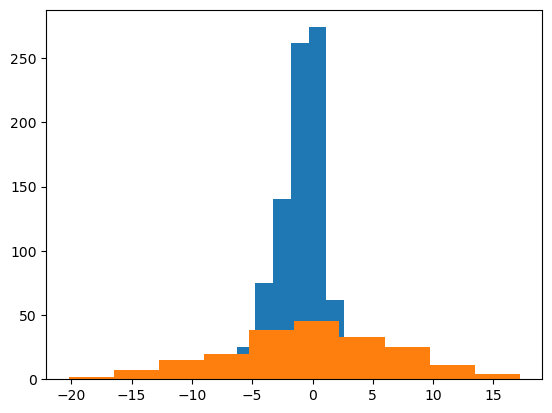

In [30]:
plt.hist(Y[0])
plt.hist(X[1][0])

In [31]:
from joblib import parallel_backend
from scipy.stats import zscore


start_time = time.time()
for i,layer in enumerate(all_layers):
    
    # Assuming X is your feature set and Y is the target variable
    X_train, X_test, Y_train, Y_test = train_test_split(X[i], Y, test_size=0.1, shuffle=False)

    Y_train = np.nan_to_num(zscore(Y_train))
    X_train = np.nan_to_num(zscore(X_train))
    X_test = np.nan_to_num(zscore(X_test))






    
    # Create a RidgeCV object
    ridge = RidgeCV(alphas=[ 1e-2, 1e-1, 1], cv=10)
    
    # Fit the model
    ridge.fit(X_train, Y_train)
    
    # Now you can use the model to predict the test set
    #_pred = ridge.predict(X_test)
    score = ridge.score(X_test, Y_test)
    print("R^2 Score: ", score)
    # clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X[i], Y)
    #print(clf.score(Y_test, Y_pred))
elapsed_time=time.time() - start_time
print(elapsed_time)


start_time = time.time()

# with parallel_backend('loky',n_jobs=4):
#     for i,layer in enumerate(all_layers):
    
#         # Assuming X is your feature set and Y is the target variable
#         X_train, X_test, Y_train, Y_test = train_test_split(X[i], Y, test_size=0.2, random_state=42)
        
#         # Create a RidgeCV object
#         ridge = RidgeCV(alphas=[ 1e-2, 1e-1, 1], cv=10)
        
#         # Fit the model
#         ridge.fit(X_train, Y_train)
        
#         # Now you can use the model to predict the test set
#         #_pred = ridge.predict(X_test)
#         score = ridge.score(X_test, Y_test)
#         print("R^2 Score: ", score)
#         # clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]).fit(X[i], Y)
#         #print(clf.score(Y_test, Y_pred))

# elapsed_time=time.time() - start_time
# print(elapsed_time)

R^2 Score:  -0.16227883736587448
R^2 Score:  -0.20831268221730753
0.9180548191070557


In [240]:
Y.shape

(739, 871)

In [241]:
X[0].shape

(739, 211)

In [32]:
# from joblib import parallel_backend

# start_time = time.time()
# with parallel_backend('loky', n_jobs=4):
#     # Your scikit-learn code here
#     r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
#     #r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =2,score_f=R2)
# elapsed_time=time.time() - start_time
# print(elapsed_time)

start_time = time.time()
# Your scikit-learn code here
#r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =5,score_f=R2)
elapsed_time=time.time() - start_time
print(elapsed_time)

16.479061603546143


In [33]:
## r2s: voxelwise R2(predictions using only one feature, data)
print('shape of r2s is (number of features, dim_Y), that is', r2s.shape)

## stacked_r2s: voxelwise R2(stacking predictions using all features, data)
print('shape of stacked_r2s is (dim_Y, ), that is', stacked_r2s.shape)

## S_average: optimzed voxelwise stacking weights showing how different features are combined
print('shape of S_average is (dim_Y, num of features), that is', S_average.shape)

shape of r2s is (number of features, dim_Y), that is (2, 871)
shape of stacked_r2s is (dim_Y, ), that is (871,)
shape of S_average is (dim_Y, num of features), that is (871, 2)


In [34]:
np.mean(stacked_r2s)

0.009132769516833512

In [20]:
stacked_r2s.max()

0.014761484505819156

In [37]:
df=pd.read_csv('../data/DM_pliers_all.csv')

In [38]:
df

,Unnamed: 0,brightness,sharpness,face_detectionConfidence,face_landmarkingConfidence,abstract,action,alphabet,animal,architecture,...,mfcc_11,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,vibrance
0,0,0.246131,1.0,0.000000,0.000000,0.167749,0.363600,0.002034,0.093345,0.533596,...,3.394691,2.047086,-2.894316,-0.286717,6.342724,5.425536,0.909868,1.663460,4.637609,501.776222
1,1,0.243845,1.0,0.000000,0.000000,0.204442,0.388526,0.003572,0.147960,0.576969,...,-8.905154,-1.781101,8.469676,-4.424966,5.635565,5.956702,-0.705075,4.817046,-0.041792,503.895218
2,2,0.244726,1.0,0.000000,0.000000,0.214081,0.381101,0.003139,0.108687,0.503560,...,-6.194043,-10.234765,2.831864,-2.648869,-0.701678,-4.219223,4.170469,6.358319,-4.099131,508.354185
3,3,0.258668,1.0,0.000000,0.000000,0.126873,0.236590,0.003892,0.105058,0.581153,...,2.028557,-11.561363,-6.274574,-6.064760,-6.904429,-5.554349,-1.078951,2.417915,-5.254695,502.173525
4,4,0.268842,1.0,0.000000,0.000000,0.264085,0.385225,0.003718,0.181262,0.641755,...,-18.749567,-17.109541,-3.418450,-7.354648,-6.871152,-2.616362,2.651057,-0.229634,-5.254941,530.951346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,595,0.106606,1.0,0.000000,0.000000,0.898762,0.517553,0.002320,0.120638,0.291205,...,2.691839,8.580536,15.911509,7.112349,12.356004,7.507671,-5.595244,-6.956372,-5.310825,104.029311
596,596,0.329696,1.0,0.000000,0.000000,0.294298,0.428923,0.001047,0.276501,0.052066,...,8.895519,10.239916,11.524013,7.770943,7.806584,3.544562,-2.694659,-2.387859,-6.526293,478.908754
597,597,0.329386,1.0,0.615383,0.130395,0.405134,0.461771,0.001875,0.109203,0.083333,...,6.899698,1.300383,4.011791,4.093169,4.888222,1.624974,2.472670,2.027416,1.623478,464.330886
598,598,0.141205,1.0,0.000000,0.000000,0.932255,0.149778,0.002502,0.041972,0.003888,...,3.187621,2.082713,-2.619781,0.160768,4.344271,3.139183,4.333610,7.584646,10.968047,191.240936


## make different types of features for fitting models and save them as npz to save time

### mean activations

In [23]:
import h5py
import numpy as np

# load the mean activations
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

X=load_audio_features('DM',all_layers)
for x in X:
    print(x.shape)

# the mean PCA(1,5,10,50,100,200)
for n_components in [1,5,10,50,100,200]:
    X=nat_asd_utils.load_audio_features_PCA('DM',all_layers,n_components)
    with h5py.File(f'../data/features/DM_cochresnet50_activations-mean_PCA-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X[i])


(749, 211)
(749, 6784)
(749, 3392)
(749, 13568)
(749, 13824)
(749, 14336)
(749, 14336)
(749, 2048)
loading features 1 PCA components
loading features 5 PCA components
loading features 10 PCA components
loading features 50 PCA components
loading features 100 PCA components
loading features 200 PCA components


### full activations

In [41]:
# the full activations:

# the full activation, PCA across time
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4']
for n_components in [1,10]:
    print(n_components)
    X=load_audio_features_PCA_new_full('DM',delay,all_layers,n_components)
    with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-local-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X[i])

# the full activation, PCA across time, mean across time
#can't do avg_pool becuase the 'time' dimension is 1...



1
0 input_after_preproc
input= (749, 211, 390)
after mean()= (749, 1, 390)
after flatten= (749, 390)
1 conv1_relu1
input= (749, 6784, 195)
after mean()= (749, 1, 195)
after flatten= (749, 195)
2 maxpool1
input= (749, 3392, 98)
after mean()= (749, 1, 98)
after flatten= (749, 98)
3 layer1
input= (749, 13568, 98)
after mean()= (749, 1, 98)
after flatten= (749, 98)
4 layer2
input= (749, 13824, 49)
after mean()= (749, 1, 49)
after flatten= (749, 49)
5 layer3
input= (749, 14336, 25)
after mean()= (749, 1, 25)
after flatten= (749, 25)
6 layer4
input= (749, 14336, 13)
after mean()= (749, 1, 13)
after flatten= (749, 13)
10
0 input_after_preproc
input= (749, 211, 390)
after mean()= (749, 10, 390)
after flatten= (749, 3900)
1 conv1_relu1
input= (749, 6784, 195)
after mean()= (749, 10, 195)
after flatten= (749, 1950)
2 maxpool1
input= (749, 3392, 98)
after mean()= (749, 10, 98)
after flatten= (749, 980)
3 layer1
input= (749, 13568, 98)
after mean()= (749, 10, 98)
after flatten= (749, 980)
4 layer2

In [39]:
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4']

for n_components in [1,10]:
    print(n_components)
    X=load_audio_features_PCA_new_mean('DM',delay,all_layers,n_components)
    with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-local-{n_components}_mean.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X[i])



1
0 input_after_preproc
input= (749, 211, 390)
after mean(pca())= (749, 1)
after flatten= (749, 1)
1 conv1_relu1
input= (749, 6784, 195)
after mean(pca())= (749, 1)
after flatten= (749, 1)
2 maxpool1
input= (749, 3392, 98)
after mean(pca())= (749, 1)
after flatten= (749, 1)
3 layer1
input= (749, 13568, 98)
after mean(pca())= (749, 1)
after flatten= (749, 1)
4 layer2
input= (749, 13824, 49)
after mean(pca())= (749, 1)
after flatten= (749, 1)
5 layer3
input= (749, 14336, 25)
after mean(pca())= (749, 1)
after flatten= (749, 1)
6 layer4
input= (749, 14336, 13)
after mean(pca())= (749, 1)
after flatten= (749, 1)
10
0 input_after_preproc
input= (749, 211, 390)
after mean(pca())= (749, 10)
after flatten= (749, 10)
1 conv1_relu1
input= (749, 6784, 195)
after mean(pca())= (749, 10)
after flatten= (749, 10)
2 maxpool1
input= (749, 3392, 98)
after mean(pca())= (749, 10)
after flatten= (749, 10)
3 layer1
input= (749, 13568, 98)
after mean(pca())= (749, 10)
after flatten= (749, 10)
4 layer2
input= 

In [43]:
# the full flattened PCA

In [6]:
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

X=load_audio_features_full(stim,all_layers)


from sklearn.decomposition import PCA
transformer = PCA(n_components=n_components)

for n_components in [1,5,10,50,100,200]:
    print('n_componentes',n_components)
    transformer = PCA(n_components=n_components)

    X_PCA=[]
    
    for xx in range(len(X)):
        transformer = PCA(n_components=n_components)
        
        data=X[xx]
        print(xx, data.shape)
        data=transformer.fit_transform(data)
        X_PCA.append(data)
        print(data.shape)
    
    with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-{n_components}.hdf5', 'w') as f:
        for i, layer in enumerate(all_layers):
            f.create_dataset(layer, data=X_PCA[i])

n_componentes 1
0 (749, 82290)
(749, 1)
1 (749, 1322880)
(749, 1)
2 (749, 332416)
(749, 1)
3 (749, 1329664)
(749, 1)
4 (749, 677376)
(749, 1)
5 (749, 358400)
(749, 1)
6 (749, 186368)
(749, 1)
7 (749, 2048)
(749, 1)
n_componentes 5
0 (749, 82290)
(749, 5)
1 (749, 1322880)
(749, 5)
2 (749, 332416)
(749, 5)
3 (749, 1329664)
(749, 5)
4 (749, 677376)
(749, 5)
5 (749, 358400)
(749, 5)
6 (749, 186368)
(749, 5)
7 (749, 2048)
(749, 5)
n_componentes 10
0 (749, 82290)
(749, 10)
1 (749, 1322880)
(749, 10)
2 (749, 332416)
(749, 10)
3 (749, 1329664)
(749, 10)
4 (749, 677376)
(749, 10)
5 (749, 358400)
(749, 10)
6 (749, 186368)
(749, 10)
7 (749, 2048)
(749, 10)
n_componentes 50
0 (749, 82290)
(749, 50)
1 (749, 1322880)
(749, 50)
2 (749, 332416)
(749, 50)
3 (749, 1329664)
(749, 50)
4 (749, 677376)
(749, 50)
5 (749, 358400)
(749, 50)
6 (749, 186368)
(749, 50)
7 (749, 2048)
(749, 50)
n_componentes 100
0 (749, 82290)
(749, 100)
1 (749, 1322880)
(749, 100)
2 (749, 332416)
(749, 100)
3 (749, 1329664)
(749, 

In [30]:
# Open the HDF5 file
#with h5py.File(f'../data/features/DM_cochresnet50_activations-mean_PCA-{n_components}.hdf5', 'r') as f:
with h5py.File(f'../data/features/DM_cochresnet50_activations-full_PCA-10.hdf5', 'r') as f:
    
    # Loop over all keys (i.e., layer names) in the file
    for key in f.keys():
        # Load the data for the current key into a numpy array
        data = f[key][...]

        # Now 'data' is a numpy array containing the data for the current layer
        print(f"{key}: {data.shape}")

avgpool: (749, 10)
conv1_relu1: (749, 10)
input_after_preproc: (749, 10)
layer1: (749, 10)
layer2: (749, 10)
layer3: (749, 10)
layer4: (749, 10)
maxpool1: (749, 10)


In [13]:

# load a (good) subject data, audio ROIs
atlas,atlas_data=nat_asd_utils.load_glasser()
sub="NDARHJ830RXD"
parcel='A1'
parcels=['A1',
    'A4',
    'A5']

atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]

delay=7

im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
img = nb.load(im_file)
img_y = img.get_fdata()
Y=img_y[delay:,atlas_indices_indices]

# load the audio features
all_layers=['input_after_preproc',
 'conv1_relu1',
 'maxpool1',
 'layer1',
 'layer2',
 'layer3',
 'layer4',
 'avgpool']

# all_layers=['input_after_preproc',
#  'conv1_relu1']

# all_layers=['input_after_preproc',
#  'layer2']

filename='DM_cochresnet50_activations-full_PCA-200.hdf5'
X=load_audio_features_processed(filename,all_layers)

X = [array[:Y.shape[0], :] for array in X]
Y= Y[:X[0].shape[0],:]


In [14]:
X[0].shape

(739, 200)

In [15]:
Y.shape

(739, 871)

In [42]:
files = glob.glob(f'../data/features/*.hdf5')
for f in files:
    
    atlas,atlas_data=nat_asd_utils.load_glasser()
    sub="NDARHJ830RXD"
    parcel='A1'
    parcels=['A1',
        'A4',
        'A5']
    
    atlas_indices,indices,parcel_names=nat_asd_utils.get_parcel_indices(atlas,parcels)
    atlas_indices_indices = np.where(np.isin(atlas_data, atlas_indices))[0]
    
    delay=7
    
    im_file = f'/nese/mit/group/sig/projects/hbn/hbn_bids/derivatives/xcp_d_0.7.1/sub-{sub}/ses-HBNsiteRU/func/sub-{sub}_ses-HBNsiteRU_task-movieDM_space-fsLR_den-91k_desc-denoisedSmoothed_bold.dtseries.nii'
    img = nb.load(im_file)
    img_y = img.get_fdata()
    Y=img_y[delay:,atlas_indices_indices]
    
    # load the audio features
    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4',
     'avgpool']

    all_layers=['input_after_preproc',
     'conv1_relu1',
     'maxpool1',
     'layer1',
     'layer2',
     'layer3',
     'layer4']
    
    # all_layers=['input_after_preproc',
    #  'conv1_relu1']
    
    # all_layers=['input_after_preproc',
    #  'layer2']
    
    #filename='DM_cochresnet50_activations-full_PCA-200.hdf5'
    filename=os.path.basename(f)
    print(filename)
    X=load_audio_features_processed(filename,all_layers)
    
    X = [array[:Y.shape[0], :] for array in X]
    Y= Y[:X[0].shape[0],:]


    
    start_time = time.time()
    # Your scikit-learn code here
    #r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'cross_val_ridge',n_folds =5,score_f=R2)
    r2s, stacked_r2s, r2s_weighted, _, _, S_average = stacking_CV_fmri(Y, X, method = 'simple_ridge',n_folds =5,score_f=R2)
    elapsed_time=time.time() - start_time
    print('time=',elapsed_time)
    print('R2=',np.mean(stacked_r2s))

DM_cochresnet50_activations-full_PCA-1.hdf5
time= 12.117755651473999
R2= 0.10015499786993952
DM_cochresnet50_activations-full_PCA-10.hdf5
time= 14.692841529846191
R2= 0.07537728795573245
DM_cochresnet50_activations-full_PCA-100.hdf5
time= 24.94187593460083
R2= 0.033468311030144936
DM_cochresnet50_activations-full_PCA-200.hdf5
time= 43.2307448387146
R2= 0.025784986974006288
DM_cochresnet50_activations-full_PCA-5.hdf5
time= 13.692887544631958
R2= 0.06998093249381906
DM_cochresnet50_activations-full_PCA-50.hdf5
time= 18.50237727165222
R2= 0.0340908982328968
DM_cochresnet50_activations-full_PCA-local-1.hdf5
time= 33.55470848083496
R2= -0.002008928436515227
DM_cochresnet50_activations-full_PCA-local-10.hdf5



KeyboardInterrupt



In [24]:
os.path.basename(f)

'DM_cochresnet50_activations-full_PCA-1.hdf5'

In [17]:
np.mean(stacked_r2s)

0.014289266337259833

### HRF?

In [5]:
# canonical HRF
# other?